# Fakenews detection
Karolina Mączka, Tymoteusz Urban

# Komentarze dopisane podczas walidacji oznaczone są za pomocą /A/

In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re
from wordcloud import WordCloud
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aleks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aleks\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aleks\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Aleks\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [277]:
# Upload danych
train=pd.read_csv('training_data.csv', header=0, sep=',')
test=pd.read_csv('testing_data.csv', header=0, sep=',')
val=pd.read_csv('fakenws_validation.csv', header=0, sep=',')

In [278]:
len(train)/sum([len(df) for df in [train, test, val]])

0.4899847925266131

/A/ Zbiór treningowy to niecałe 50% całego zbioru danych - mógłby być trochę większy,
przy zbyt małym zbiorze treningowym model może funckjonować nieefektywnie

## Train test split

/A/ Zweryfikujmy, czy wartości z targetu są rozdystrybuowane podobnie w zbiorach train, test, val

In [279]:
for target in [train['label'], test['label'], val['label']]:
    print(target.value_counts())
    print('Proporcja true/fake:',
          len(target[target=='true'])/len(target[target=='fake']),
          '\n')

fake    20645
true    13186
Name: label, dtype: int64
Proporcja true/fake: 0.6387018648583193 

fake    12700
true     8014
Name: label, dtype: int64
Proporcja true/fake: 0.631023622047244 

fake    8814
true    5686
Name: label, dtype: int64
Proporcja true/fake: 0.6451100521896982 



/A/ Proporcje w targecie są zachowane w każdym ze zbiorów danych

In [280]:
df_train = train.copy()
df_testing = test.copy()
df_validate= val.copy()

In [281]:
df2 = df_validate # ułatwienie pracy z notebookiem

## Getting to know the data

In [282]:
df2.head()

,title,text,label
0,"They Said What?!: Find Out What Reba McEntire,...",Email Ever wonder what’s on the mind of today’...,fake
1,Macron's European dream more difficult without...,PARIS (Reuters) - President Emmanuel Macron s ...,true
2,FLASHBACK VIDEO: JESSE JACKSON Praises Donald ...,Oops! Hillary and her race-baiting campaign te...,fake
3,Markets ignore Trump presidential bid at their...,LONDON (IFR) - The prospect of Donald Trump be...,true
4,Dem insiders: Sanders failed to dent Clinton,"Killing Obama administration rules, dismantlin...",true


In [283]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14500 entries, 0 to 14499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   14368 non-null  object
 1   text    14486 non-null  object
 2   label   14500 non-null  object
dtypes: object(3)
memory usage: 340.0+ KB


/A/ Nie ma braków w targecie, specyficzny zbiór danych wymagający przetworzenia adekwatnego dla NLP.
Niewielka ilość braków w kolumnach text i title, szczególnie braki w 'text' zwracają uwage bo to kluczowa kolumna



## Data Preprocessing

### Encoding

In [284]:
# zamina fake i true na wartości numeryczne
df2.loc[df2["label"] == "fake","label"] = 0
df2.loc[df2["label"] == "true","label"] = 1

In [285]:
# before pipeline function
def encodeLabels(df):
    df.loc[df["label"] == "fake","label"] = 0
    df.loc[df["label"] == "true","label"] = 1
    return df

### NaNs

/A/ Lepiej wstępnie przeanalizować jak wyglądają braki danych, zamiast od razu się ich pozbywać

In [286]:
# /A/ przyjrzenie się tytułom bez tekstu
df2[df2['text'].isna()]['title']

257      Il saoule tout le monde avec son analyse polit...
926                            Ravens @ Raiders - Thursday
989      New U.N. Report Cites Terrorists, Blames Assad...
1083                    The Prophet of Germany’s New Right
1411     La Corée du Nord annonce avoir envoyé un missi...
2663     La Trump Tower cambriolée – les voleurs seraie...
3061     Donald Trump s’excuse pour toutes les minorité...
4208     La sortie du dernier livre inédit du Gorafi éc...
6446     Le top des recherches Google passe en top des ...
9348     10/6 Post-Season: WS: Beat Boston,Lose Two To ...
12115                 Donald Trump en 5 dates >> Le Gorafi
12266    Sur Twitter, Donald Trump se félicite d’avoir ...
13236    10/4 Expo Park-Forbes Field Era: '08 To the Wi...
13493    La Russie a profité de l’élection américaine p...
Name: title, dtype: object

In [287]:
# /A/ przyjrzenie się tekstom bez tytułu
df2[df2['title'].isna()]['text']

146      A leading US senator: US Supporting War in Syr...
282      They’re too busy liking bullshit memes and wat...
308      $2.9B/year could have taken care of many highw...
512      Lying, arrogant Muslim, Marxist piece of dogsh*t.
620      There are a ton of tards who will continue to ...
                               ...                        
13919    Wait till you see what happens to the valuatio...
13995    JUST VOTE TRUMP LETs PUT THE HAG OUT TO PASTUR...
14070      Yes... AARP opposed Single Payer. Boycott them.
14316    Same people all the time , i dont know how you...
14452    A leading US senator: US Supporting War in Syr...
Name: text, Length: 132, dtype: object

In [288]:
# Jest bardzo mało nulli więc możemy się ich pozbyć
df2.dropna(inplace = True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14354 entries, 0 to 14499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   14354 non-null  object
 1   text    14354 non-null  object
 2   label   14354 non-null  object
dtypes: object(3)
memory usage: 448.6+ KB


In [289]:
# transformer function
def handleNa(df):
    df.dropna(inplace=True)
    print('NaNs deleted')
    return df

### Combine columns

In [290]:
# Z racji, że będziemy analizować same słowa, łączymy kolumny title i tekst 
# - dla naszego modelu nie będzie miało znaczenia z której kolumny pochodzą

In [291]:
df2.loc[8102]

title    ALL HELL IS BREAKING LOOSE IN GERMANY: Citizen...
text     Enough is enough! German citizens are witnessi...
label                                                    0
Name: 8102, dtype: object

In [292]:
df2['text'] = df2[['title', 'text']].apply(" ".join, axis=1)

In [293]:
df2.loc[8102]['text']

'ALL HELL IS BREAKING LOOSE IN GERMANY: Citizens Want “Refugees” Gunned Down At Borders [VIDEO] Enough is enough! German citizens are witnessing the fast-track decline of their nation. Does America need to look any further than Germany to see that bringing in hundreds of thousands (in Germany s case millions) of Muslim men from countries who have no interest in assimilating in the Western world, is a serious threat to its citizens?  Liberal open-border policies that have been put forth by Angel Merkel and other progressives in power have clearly put their citizens in grave danger. OVER one-in-four Germans say they back a policy to open fire on unwanted illegal refugees at their borders.Watch massive brawl break out in refugee camp over torn Quran:The Alternative for Germany (AFD) party leader Frauke Petry caused a storm a week ago when she advocated the right of border police to gun down migrants. But her comments have struck a nerve in a country being pushed to the brink by the crisis

In [294]:
#df2 = df2.drop(columns='title')

/A/ Moglibyśmy zostawić kolumnę 'title', może niosłaby wartościowe informacje 
np. często fake newsy i baity mają tytuły zapisane z użyciem wielkich liter

In [295]:
# /A/ przykładowy kod który można wykorzystać do sprawdzenia ile wielkich liter w tytule
def uppercase_percentage(text):
    if not isinstance(text, float) : # sprawdzamy czy wartość nie jest pusta
        return(sum(1 for c in text if c.isupper())/len(text))

def count_uppercase_percentage(df):
    df['title_uppercase_percentage'] = df['title'].apply(uppercase_percentage)

count_uppercase_percentage(df2)

In [296]:
df2.head(5)

,title,text,label,title_uppercase_percentage
0,"They Said What?!: Find Out What Reba McEntire,...","They Said What?!: Find Out What Reba McEntire,...",0,0.184783
1,Macron's European dream more difficult without...,Macron's European dream more difficult without...,1,0.047619
2,FLASHBACK VIDEO: JESSE JACKSON Praises Donald ...,FLASHBACK VIDEO: JESSE JACKSON Praises Donald ...,0,0.314516
3,Markets ignore Trump presidential bid at their...,Markets ignore Trump presidential bid at their...,1,0.038462
4,Dem insiders: Sanders failed to dent Clinton,Dem insiders: Sanders failed to dent Clinton K...,1,0.068182


In [297]:
# transformer function
def combineColumns(df):
    df['text'] = df[['title', 'text']].apply(" ".join, axis=1)
    df = df.drop(columns='title')
    print('Columns combined')
    return df

### Outliers

In [ ]:
df2['textlength'] = df2['text'].apply(len)
plt.hist(df2['textlength'])

In [ ]:
print(df2[(df2['textlength'] > 40000)].count())
df2[(df2['textlength'] > 40000)].head()

In [ ]:
# Wyrzucamy bardzo dlugie teksty (ponad 40000 znaków)
df2 = df2[(df2['textlength'] < 40000)]
df2.drop(columns='textlength')

/A/ bardzo długich tekstów jest bardzo niewiele
(może warto było zweryfikować czego dotyczą przed wyrzuceniem)

/A/ Nie wiem czy ich eliminacja jest konieczna

In [ ]:
# transformer function
def removeOutliers(df):
    df['textlength'] = df['text'].apply(len)
    df = df[df['textlength'] < 40000]
    df = df.drop(columns='textlength')
    print('Outliers removed')
    return df

### Removing stopwords

In [298]:
#stopword removal
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
def remove_stopwords(s):
    s = [lemmatizer.lemmatize(word.lower()) for word in s if not word.lower() in stop]
    return s

In [299]:
# punctuation and number removal
def remove_punctuations(s):
    s = re.sub(r'[^a-zA-Z\s]', '', s)
    return s

In [300]:
df2['text'] = df2['text'].apply(remove_punctuations)
df2['text'] = df2['text'].apply(word_tokenize)

In [301]:
df2['text'] = df2['text'].apply(remove_stopwords)

/A/ odpowiednie podejście w wypadku NLP, dobrze że tekst został stokenizowany i usunięto interpunkcję

In [303]:
def list2string(text):
    text = " ".join(wrd for wrd in text)
    return text

In [304]:
df3 = df2.copy()

In [305]:
df3["text"] = df3["text"].apply(list2string)
df3.head()

,title,text,label,title_uppercase_percentage
0,"They Said What?!: Find Out What Reba McEntire,...",said find reba mcentire whoopi goldberg pope f...,0,0.184783
1,Macron's European dream more difficult without...,macron european dream difficult without strong...,1,0.047619
2,FLASHBACK VIDEO: JESSE JACKSON Praises Donald ...,flashback video jesse jackson praise donald tr...,0,0.314516
3,Markets ignore Trump presidential bid at their...,market ignore trump presidential bid peril lon...,1,0.038462
4,Dem insiders: Sanders failed to dent Clinton,dem insider sander failed dent clinton killing...,1,0.068182


In [306]:
# transformer function
def removeStopwords(df):
    df['text'] = df['text'].apply(remove_punctuations)
    print('Punctuation removed')
    df['text'] = df['text'].apply(word_tokenize)
    print('Words tokenized')
    df['text'] = df['text'].apply(remove_stopwords)
    print('Stopwords removed')
    df['text'] = df['text'].apply(list2string)
    return df

### Extracting english

In [185]:
# def deleteUrl(text):
#     return re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', text)

/A/ Według mnie szkoda tracić informację o ilości linków w tekście - może się okazać wartościowa
Na potrzeby poniższej analizy mówiącej które z tekstów były samymi linkami można by utworzyć po prostu
nową kolumnę gdzie znajdowałby się tekst bez linków

In [309]:
# /A/ przykładowy kod służący do policzenia wystąpień linków

# /A/ potrzebujemy stokenizowanego tekstu
df3['tokenized_text'] = df3['text'].apply(word_tokenize)

def count_urls(df):
    df['url_amount'] = df['tokenized_text'].apply(
        lambda row: len([word for word in row if 'http' in word or 'https' in word])
    )

In [311]:
# /A/
count_urls(df3)
df3.head(5)

,title,text,label,title_uppercase_percentage,tokenized_text,url_amount
0,"They Said What?!: Find Out What Reba McEntire,...",said find reba mcentire whoopi goldberg pope f...,0,0.184783,"[said, find, reba, mcentire, whoopi, goldberg,...",0
1,Macron's European dream more difficult without...,macron european dream difficult without strong...,1,0.047619,"[macron, european, dream, difficult, without, ...",0
2,FLASHBACK VIDEO: JESSE JACKSON Praises Donald ...,flashback video jesse jackson praise donald tr...,0,0.314516,"[flashback, video, jesse, jackson, praise, don...",1
3,Markets ignore Trump presidential bid at their...,market ignore trump presidential bid peril lon...,1,0.038462,"[market, ignore, trump, presidential, bid, per...",0
4,Dem insiders: Sanders failed to dent Clinton,dem insider sander failed dent clinton killing...,1,0.068182,"[dem, insider, sander, failed, dent, clinton, ...",0


In [186]:
# usuwamy linki
df3['text'] = df3['text'].apply(deleteUrl)

In [187]:
# tworzymy krótszą kolumnę do analizy języka
def shortenText(text):
    return text[:60]

In [188]:
df3['shorttext'] = df3['text'].apply(shortenText)

In [189]:
df3['shorttext'][1]

'french foreign minister say accepting refugee duty paris reu'

In [190]:
df3[df3['shorttext'].apply(len) < 10]

,text,label,textlength,shorttext
1679,,0,2829,
2440,,0,1318,
2843,,0,1702,
4271,,0,1544,
4454,pravdaru,0,2780,pravdaru
5735,rt,0,1158,rt
6282,wallmart,0,1834,wallmart
6587,,0,6525,
6977,,0,1814,
7582,,0,2548,


In [191]:
# usuwamy teksty które mają mniej niż 10 znaków - były to same linki
df3 = df3[df3['shorttext'].apply(len) > 10]

/A/ Usunięcie bardzo krótkich tekstów ma sens

In [192]:
df3.head()

,text,label,textlength,shorttext
0,johnson sirleaf exit liberian thankful peace e...,1,4804,johnson sirleaf exit liberian thankful peace e...
1,french foreign minister say accepting refugee ...,1,1425,french foreign minister say accepting refugee ...
2,caved late july day past summer roar filled sk...,1,6858,caved late july day past summer roar filled sk...
3,obama sign executive order declaring investiga...,0,5422,obama sign executive order declaring investiga...
4,florida shooting trump hardens stance muslim m...,1,4990,florida shooting trump hardens stance muslim m...


In [193]:
df4 = df3.copy()

In [194]:
DetectorFactory.seed = 0
df4['lang'] = df4['shorttext'].apply(detect)

In [195]:
len(df4[df4['lang']!='en'])/len(df4)

0.1322435395458105

/A/ dobrze zweryfikować jaki procent naszych danych zostanie usunięta

In [196]:
# robimy model który będzie wykrywał po angielsku
df4 = df4[df4['lang']=='en']

In [197]:
df4 = df4[['text', 'label']].reset_index(drop=True)
df4

,text,label
0,johnson sirleaf exit liberian thankful peace e...,1
1,french foreign minister say accepting refugee ...,1
2,caved late july day past summer roar filled sk...,1
3,obama sign executive order declaring investiga...,0
4,florida shooting trump hardens stance muslim m...,1
...,...,...
17725,polish president back judicial reform spat war...,1
17726,ucla player hold press conferencefinally thank...,0
17727,trump son clarifies gas chamber comment critic...,1
17728,world leader congratulate trump putin anxious ...,0


In [198]:
#transformer function
def dropLanguages(df):
    DetectorFactory.seed = 0
    df['text'] = df['text'].apply(deleteUrl)
    df['shorttext'] = df['text'].apply(shortenText)
    df = df[df['shorttext'].apply(len) > 10]
    print('Text cleaned')
    df['lang'] = df['shorttext'].apply(detect)
    df = df[df['lang']=='en']
    df = df.drop(columns=['shorttext', 'lang'])
    print('Languages dropped')
    return df

In [199]:
# żeby zapisać dane
df4.to_csv('train_data.csv', index=False)

### Word Cloud

In [200]:
df_fake = df4[df4["label"] == 0]
df_true = df4[df4["label"] == 1]

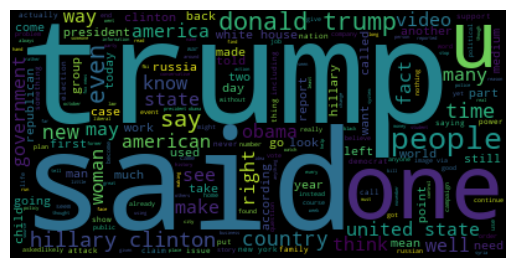

In [201]:
# Fałszywe
consolidated_f = ' '.join(
    word for word in df_fake['text'].astype(str))
wordcloud = WordCloud().generate(consolidated_f)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

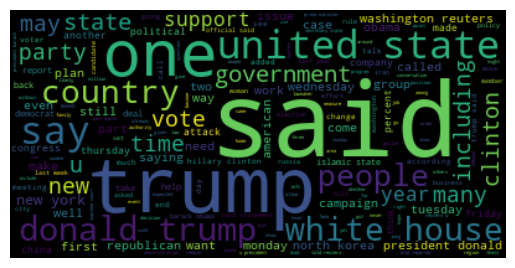

In [202]:
# Prawdziwe
consolidated_t = ' '.join(
    word for word in df_true['text'].astype(str))
wordcloud = WordCloud().generate(consolidated_t)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

/A/ ogólnie sama idea zweryfikowania jakie słowa pojawiają się w fake newsach i prawdziwych informacjach
jest według mnie bardzo trafna i można w ten sposób wyciągnąć użyteczne dane.

Jedyne co bym zmienił to sposób analizy tych danych - word cloud jest dosyć chaotyczny.
Zamiast tego może lepiej by było zrobić np listy top 100 w obydwu kategoriach i zweryfikować jak bardzo
pokrywają. 

In [203]:
# Bag of words - liczba wystąpień każdego słowa w danym tekście
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df4['text'])

In [204]:
#Transformer function
def myCountVectorizer(df):
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(df['text'])

In [205]:
# Zamiana częstości w częstotliwość wystąpień
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [59]:
X_train_tfidf.shape

(29118, 178407)

## Pipeline

In [206]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

na_transformer = FunctionTransformer(handleNa)
column_transformer = FunctionTransformer(combineColumns)
outliers_transformer = FunctionTransformer(removeOutliers)
stopwords_transformer = FunctionTransformer(removeStopwords)
language_transformer = FunctionTransformer(dropLanguages)

custom_pipe = Pipeline([
    ("na", na_transformer),
    ('columns', column_transformer),
    ('outliers', outliers_transformer),
    ("stopwords", stopwords_transformer),
    ("language", language_transformer),
])

model_pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])

In [110]:
train = pd.read_csv('training_data.csv', index_col=False)

In [207]:
train

,title,text,label
0,In the Western World Respect for Law No Longer...,In the Western World Respect for Law No Longer...,fake
1,"WATCH: President Obama Unleashes On Trump, Sa...",During an interview on CBS s Face the Nation S...,fake
2,THE GUY WHO Punched “Moldylocks” Speaks Out Ab...,Nathan Domingo is the founder of Identity Eur...,fake
3,SAY WHAT? AMAZON TELLS CUSTOMER THEY WERE FORC...,"When it comes to limiting our free speech, not...",fake
4,ANTI-GUN Zealot KATIE COURIC Hit With $12 MILL...,Little Miss Sunshine has fooled a lot of peo...,fake
...,...,...,...
33826,STATE’S ATTORNEY LIED: BALTIMORE POLICE HAD PR...,Marilyn Mosby held a press conference today in...,fake
33827,Russia denies its planes killed civilians in S...,MOSCOW (Reuters) - Russia s Defence Ministry d...,true
33828,Hungary’s “Wall” Versus the U.S. “Wall”,Op-Ed by Catherine J. Frompovich\r\nCurrently ...,fake
33829,Pastor Caught Trump’s Spiritual Advisor Steal...,It seems that Donald Trump s spiritual advisor...,fake


In [208]:
train = encodeLabels(train)

In [209]:
train_transformed = custom_pipe.transform(train)

NaNs deleted
Columns combined
Outliers removed
Punctuation removed
Words tokenized
Stopwords removed
Text cleaned


KeyboardInterrupt: 

In [ ]:
train_transformed

In [117]:
train_transformed_x = train_transformed['text']
train_transformed_y = train_transformed['label']

In [118]:
train_xx = model_pipe.fit_transform(train_transformed_x, train_transformed_y)

In [119]:
train_xx.shape

(29070, 178186)